# Feature Extraction for Skin Classification  

William Chen, Gokul Srinivasan, Avani Kuthe, XingJian Diao

COSC 89.2 Data Science for Health

Nov. 2022

In [153]:
import cv2
import pandas as pd
import numpy as np 
import skimage as skmg
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math 
from tqdm import tqdm
from random import *
from PIL import Image
import os
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
#from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from skimage import data, color, feature
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage.util import random_noise
from scipy.stats import uniform
from scipy import ndimage
from scipy.spatial import distance
from scipy.cluster.vq import vq
from skimage import filters
import statistics

## Data Ingestion

In [27]:
# Get the metadata and diagnoses
df = pd.read_csv("./HAM10000/HAM10000_metadata.csv")
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [28]:
# Label encoder for diagnoses
lb = LabelEncoder()
lb.fit_transform(df['dx'])
cls2lbl = {cls: idx for idx, cls in enumerate(lb.classes_)}
lbl2cls = {idx: cls for idx, cls in enumerate(lb.classes_)}
df['label'] = [cls2lbl[cls] for cls in df['dx']]

In [5]:
cls2lbl

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [6]:
# Read in images 
sds = ["./HAM10000/HAM10000_images_part_1/", "./HAM10000/HAM10000_images_part_2/"]
imgs = []
dsize = ()

# Get the images, downsized by factor of 4
for sd in sds:
    filelist = [f for f in os.listdir(sd)]
    for file in tqdm(filelist):
        img = cv2.cvtColor(cv2.imread(sd+file), cv2.COLOR_BGR2RGB)
        dsize = (int(img.shape[1] * 0.25), int(img.shape[0] * 0.25)) # Downsize by factor of 4
        imgs.append(cv2.resize(img, dsize))

100%|██████████| 5015/5015 [00:45<00:00, 109.73it/s]


In [7]:
# Get segmentation masks  
dir = "HAM10000/HAM10000_segmentations_lesion_tschandl/HAM10000_segmentations_lesion_tschandl/"
masks = []
masklist = [f for f in os.listdir(dir)]   
for f in tqdm(masklist):
    m = cv2.cvtColor(cv2.imread(dir+f),cv2.COLOR_BGR2GRAY)
    dsize = (int(m.shape[1] * 0.25), int(m.shape[0] * 0.25)) # Downsize by factor of 4
    masks.append(cv2.resize(m, dsize))


100%|██████████| 10015/10015 [00:40<00:00, 250.32it/s]


## Scale Invariant Feature Transformation (SIFT)

Approach inspired by https://machinelearningknowledge.ai/image-classification-using-bag-of-visual-words-model/, https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb, https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f, and https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/

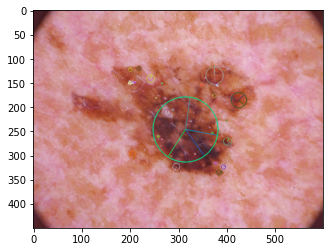

In [348]:
# example of SIFT feature extraction
testimg2 = cv2.cvtColor(cv2.imread(sds[0]+"ISIC_0024310.jpg"), cv2.COLOR_BGR2RGB)
testmask2 = cv2.cvtColor(cv2.imread(dir+"ISIC_0024310_segmentation.png"), cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create(50)
kp, des = sift.detectAndCompute(testimg2,testmask2)
img_sift2=cv2.drawKeypoints(testimg2,kp,testimg2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_sift2)

In [32]:
# Perform feature extraction using SIFT
sift_features = []
sift_numfeatures = []
for i in tqdm(range(len(imgs))):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(imgs[i],masks[i])
    sift_features.append(des)
    #sift_numfeatures.append(des.shape[0])

100%|██████████| 10015/10015 [00:16<00:00, 593.65it/s]


In [33]:
len(sift_features)

10015

In [34]:
for n in sift_features:
    if n is None:
        sift_numfeatures.append(0)
    else:
        sift_numfeatures.append(n.shape[0])    

In [35]:
df["sift_num"] = sift_numfeatures
df["sift_features"] = sift_features

In [37]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,sift_num,sift_features
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,4,"[[4.0, 32.0, 10.0, 22.0, 34.0, 0.0, 0.0, 0.0, ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,3,"[[110.0, 60.0, 46.0, 3.0, 0.0, 0.0, 1.0, 37.0,..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,14,"[[69.0, 18.0, 4.0, 0.0, 0.0, 0.0, 0.0, 13.0, 3..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,2,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,73,"[[55.0, 143.0, 40.0, 0.0, 0.0, 0.0, 0.0, 6.0, ..."


In [38]:
df.groupby('dx')['sift_num'].mean()

dx
akiec    16.944954
bcc      12.918288
bkl      12.269336
df       13.565217
mel      14.254268
nv       14.783296
vasc     18.330986
Name: sift_num, dtype: float64

In [200]:
statistics.median(sift_numfeatures)

7

(array([8.84e+03, 8.13e+02, 2.30e+02, 7.60e+01, 2.60e+01, 1.80e+01,
        8.00e+00, 2.00e+00, 1.00e+00, 1.00e+00]),
 array([  0. ,  31.7,  63.4,  95.1, 126.8, 158.5, 190.2, 221.9, 253.6,
        285.3, 317. ]),
 <BarContainer object of 10 artists>)

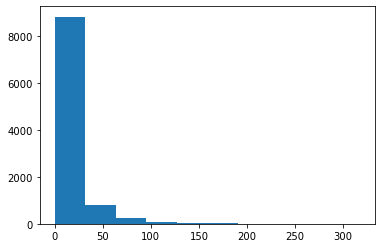

In [199]:
# Number of features extracted by SIFT 
plt.hist(sift_numfeatures)

In [39]:
# Samples where SIFT failed to extract any keypoints 
zero_df = df[df['sift_num']==0]
zero_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,sift_num,sift_features
31,HAM_0005772,ISIC_0031159,bkl,histo,60.0,female,face,2,0,None
39,HAM_0003847,ISIC_0028560,bkl,histo,85.0,male,upper extremity,2,0,None
82,HAM_0001773,ISIC_0024832,bkl,histo,40.0,female,face,2,0,None
85,HAM_0002127,ISIC_0029837,bkl,histo,40.0,male,face,2,0,None
117,HAM_0007179,ISIC_0025906,bkl,histo,0.0,female,back,2,0,None


In [186]:
missing = zero_df.groupby('dx')['label'].value_counts().tolist()
full = df.groupby('dx')['label'].value_counts().tolist()

In [196]:
# Percent of data with no features extracted
sum(missing)/sum(full)*100

2.406390414378432

In [192]:
perc_missing = []
for i in range(len(missing)):
    perc_missing.append(missing[i]/full[i]*100)
perc_missing

[0.6116207951070336,
 3.11284046692607,
 2.3657870791628755,
 2.608695652173913,
 3.054806828391734,
 2.371364653243848,
 0.7042253521126761]

In [47]:
nonzero_df = df[df['sift_num']>0]

In [350]:
categorical_cts = nonzero_df["dx"].value_counts()
categorical_cts

nv       6546
mel      1079
bkl      1073
bcc       498
akiec     325
vasc      141
df        112
Name: dx, dtype: int64

### Downsampling 

In [351]:
# Downsample the nv class by factor of 5
nv_df = nonzero_df[nonzero_df["dx"] == "nv"].sample(n=int(categorical_cts[0]/5))
other_df = nonzero_df[nonzero_df["dx"] != "nv"]

In [352]:
nv_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,sift_num,sift_features
3061,HAM_0007203,ISIC_0031845,nv,follow_up,55.0,male,upper extremity,5,86,"[[50.0, 144.0, 33.0, 0.0, 0.0, 0.0, 0.0, 2.0, ..."
5236,HAM_0004843,ISIC_0031280,nv,follow_up,60.0,male,foot,5,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8722,HAM_0007477,ISIC_0025950,nv,histo,25.0,male,back,5,4,"[[23.0, 33.0, 10.0, 6.0, 1.0, 0.0, 1.0, 11.0, ..."
8626,HAM_0001318,ISIC_0028305,nv,histo,50.0,female,lower extremity,5,56,"[[13.0, 7.0, 6.0, 63.0, 42.0, 1.0, 1.0, 5.0, 1..."
7318,HAM_0004574,ISIC_0033850,nv,histo,70.0,female,back,5,41,"[[8.0, 38.0, 1.0, 2.0, 60.0, 114.0, 21.0, 5.0,..."


In [353]:
# Downsampled nv class + original images for all other classes 
final_features = nv_df["sift_features"].tolist()+other_df["sift_features"].tolist()
final_lbls = nv_df["label"].tolist()+other_df["label"].tolist()

In [354]:
len(final_features)

4537

In [355]:
x_train, x_test, y_train, y_test = train_test_split(final_features, final_lbls, test_size=0.2, stratify = final_lbls)

In [356]:
len(x_train)

3629

In [357]:
x_train[0].shape

(37, 128)

In [358]:
bovw_dict = {} 
x_train_sift = [] # All training descriptors stored together 
for x in tqdm(range(len(x_train))):
    for item in x_train[x]:
        if y_train[x] not in bovw_dict.keys():
            bovw_dict[y_train[x]] = [item]
        else:
            bovw_dict[y_train[x]].append(item)
        x_train_sift.append(item)    

100%|██████████| 3629/3629 [00:00<00:00, 137943.77it/s]


In [359]:
# Kmeans clustering to find optimal set of features
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
visual_words = kmeans(50, x_train_sift) # 50 visual features from all the training descriptors 
#visual_words = kmeans(200, x_train_sift)

In [360]:
visual_words.shape

(50, 128)

In [361]:
sift_features[0].shape
vq(sift_features[0], visual_words) # Returns histogram of visual words 

(array([ 4, 27, 27, 27]),
 array([254.6331217 , 130.09473783, 139.61345687, 122.27427517]))

In [362]:
# Construct histogram of features for each image 
def image_histo(features, centers):
    features_histo = []
    for f in features:
        vals = vq(f, visual_words)
        histogram = np.zeros(len(centers)) # Initialize histogram
        for v in vals[0]:
            histogram[v] += 1
        features_histo.append(histogram)
    return features_histo
    
# Creates histograms for train data    
train_histo = image_histo(x_train, visual_words) 
# Creates histograms for test data
test_histo = image_histo(x_test, visual_words) 

In [363]:
# Normalization
stdslr=StandardScaler(copy = False)
train_histo_norm = stdslr.fit_transform(train_histo)
test_histo_norm=stdslr.transform(test_histo)

Accuracy on test set: 0.29295154185022027
AUC Score: 0.5388990202884337


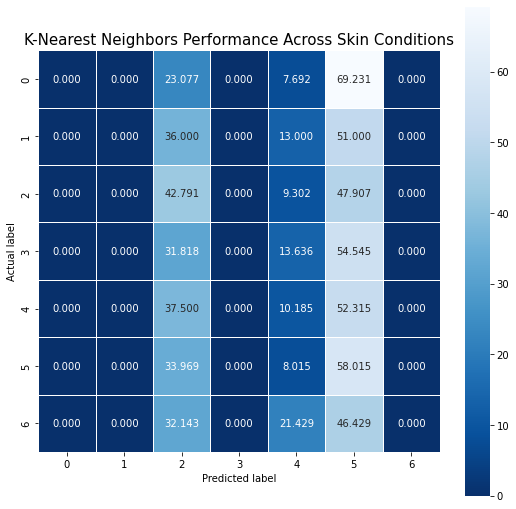

In [394]:
knn = KNeighborsClassifier(n_neighbors=300)
knn.fit(train_histo_norm, y_train)
print("Accuracy on test set: "+str(knn.score(test_histo_norm, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, knn.predict_proba(test_histo_norm), multi_class='ovr')))
plot_confusion(knn, test_histo_norm, y_test, "K-Nearest Neighbors")

Accuracy score on test set: 0.28854625550660795


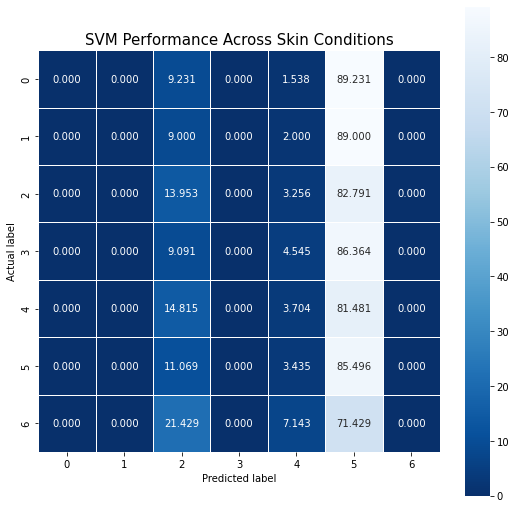

In [388]:
#Hyperparamter tuning notes:
# rbf is best kernel
# C=1 is good, changing orders of magnitude higher or lower results in same or worse performance 
# Changing gamma results in no difference 
svc_model = SVC()
svc_model.fit(train_histo_norm, y_train)
print("Accuracy score on test set: "+str(svc_model.score(test_histo_norm, y_test)))
plot_confusion(svc_model, test_histo_norm, y_test, "SVM")

Accuracy on test set: 0.2698237885462555
AUC Score: 0.5349881543406342


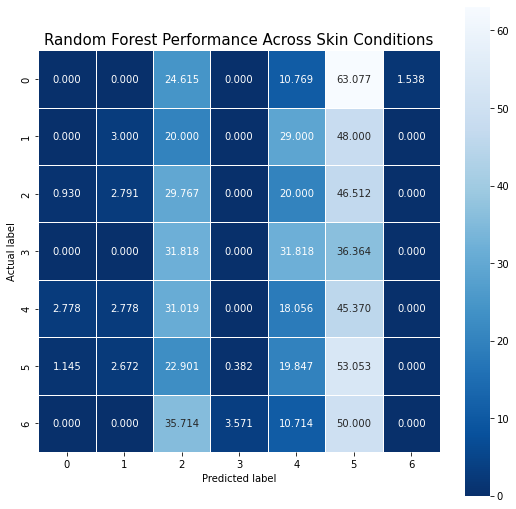

In [423]:
rf_model = RandomForestClassifier(n_estimators = 360)
rf_model.fit(train_histo_norm, y_train)
print("Accuracy on test set: "+str(rf_model.score(test_histo_norm, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, rf_model.predict_proba(test_histo_norm), multi_class='ovr')))
plot_confusion(rf_model, test_histo_norm, y_test, "Random Forest")

## Histogram of Oriented Gradients (HOG)

Approach inspired by https://debuggercafe.com/image-recognition-using-histogram-of-oriented-gradients-hog-descriptor/

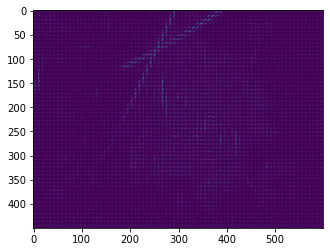

In [320]:
# Example image with HOG feature extraction
testimg = cv2.cvtColor(cv2.imread(sds[0]+"ISIC_0024306.jpg"), cv2.COLOR_BGR2RGB)
testmask = cv2.cvtColor(cv2.imread(dir+"ISIC_0024306_segmentation.png"), cv2.COLOR_BGR2GRAY)
(hog, hog_image) = feature.hog(testimg, multichannel = True, visualize=True, transform_sqrt=True, feature_vector = True)
plt.imshow(hog_image)
# orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', 

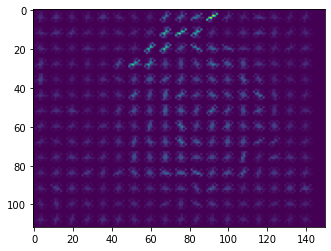

In [323]:
(hog, hog_image) = feature.hog(imgs[0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', 
                      multichannel = True, visualize=True, transform_sqrt=True, feature_vector = True)
plt.imshow(hog_image)

In [324]:
len(hog)

7956

In [325]:
# Extract features from each images using HOG
hog_features = []
for i in tqdm(range(len(imgs))):
    hog = feature.hog(imgs[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', 
                      multichannel = True, visualize=False, transform_sqrt=True, feature_vector = True)
    hog_features.append(hog)

100%|██████████| 10015/10015 [01:12<00:00, 137.37it/s]


In [326]:
df["hog"] = hog_features

In [431]:
# Downsample by factor of 5 to correct for class imbalance 
nv_df = df[df["dx"] == "nv"].sample(n=int(categorical_cts[0]/5))
other_df = df[df["dx"] != "nv"]
final_features = nv_df["hog"].tolist()+other_df["hog"].tolist()
final_lbls = nv_df["label"].tolist()+other_df["label"].tolist()

In [432]:
x_train, x_test, y_train, y_test = train_test_split(final_features, final_lbls, test_size=0.2, stratify =final_lbls)

Accuracy on test set: 0.26515151515151514
AUC Score: 0.5124341046213913


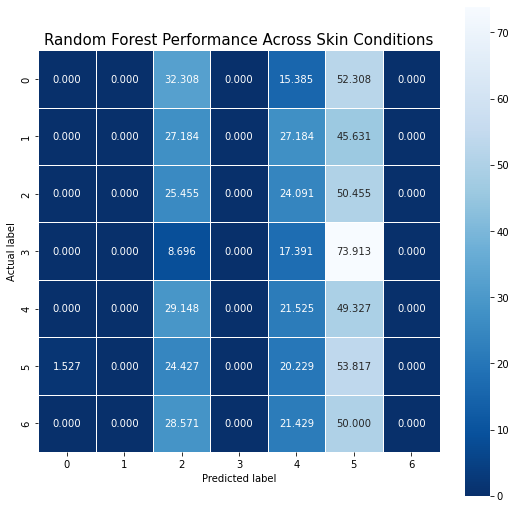

In [344]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
print("Accuracy on test set: "+str(rf_model.score(x_test, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, rf_model.predict_proba(x_test), multi_class='ovr')))
plot_confusion(rf_model, x_test, y_test, "Random Forest")

Accuracy score on test set: 0.2727272727272727


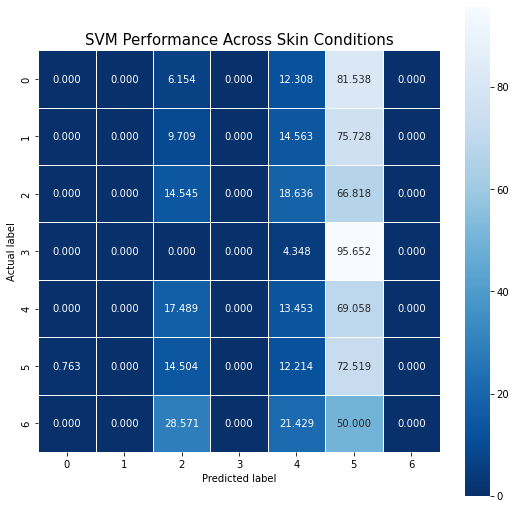

In [349]:
svc_model = SVC()
svc_model.fit(x_train, y_train)
print("Accuracy score on test set: "+str(svc_model.score(x_test, y_test)))
plot_confusion(svc_model, x_test, y_test, "SVM")



Accuracy on test set: 0.2824675324675325
AUC Score: 0.5174191028312273


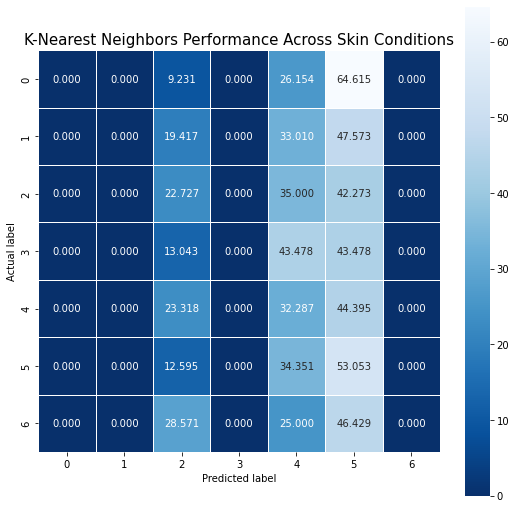

In [443]:
knn = KNeighborsClassifier(n_neighbors=500)
knn.fit(x_train, y_train)
print("Accuracy on test set: "+str(knn.score(x_test, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, knn.predict_proba(x_test), multi_class='ovr')))
plot_confusion(knn, x_test, y_test, "K-Nearest Neighbors")

In [ ]:
# Gradient boosting
grad_boost = GradientBoostingClassifier().fit(x_train, y_train)
print("Accuracy on test set: "+str(grad_boost.score(x_test, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, grad_boost.predict_proba(x_test), multi_class='ovr')))
plot_confusion(grad_boost, x_test, y_test, "Gradient Boosting")

In [ ]:
logistic_model = LogisticRegression(max_iter = 1000, multi_class = 'multinomial')
logistic_model.fit(x_train, y_train)
print("Accuracy on test set: "+str(logistic_model.score(x_test, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, logistic_model.predict_proba(x_test), multi_class='ovr')))
plot_confusion(logistic_model, x_test, y_test, "Logistic Regression")

## Model Training and Evaluation

In [231]:
# Run randomized search for hyperparameter tuning 
def hyperparameter_tuning(model, param_grid):
    param_search = RandomizedSearchCV(model, param_grid, random_state=0).fit(training_pc, y_train)
    return param_search.best_params_

In [232]:
# Plot confusion matrix
def plot_confusion(model, x, y, model_name):
    cm = confusion_matrix(y, model.predict(x), normalize = 'true')*100
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(model.score(x, y))
    plt.title(model_name+" Performance Across Skin Conditions", size = 15);

### Support Vector Machine

In [ ]:
# Run randomized search for hyperparameter tuning 
svc_param_grid = {"C":uniform(loc=0, scale=5), "kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
                  "shrinking":[True, False]}
svc_search = RandomizedSearchCV(svc_model, svc_param_grid, random_state=0).fit(training_pc, y_train)
svc_search.best_params_

### Random Forest

In [ ]:
rf_param_grid = {"n_estimators":[n for n in range(1, 500)], "max_depth":["None"]+[n for n in range(1, 50)], 
                 "criterion":["gini", "entropy", "log_loss"], "min_samples_split":[n for n in range(2, 11)],
                 "min_samples_leaf":[n for n in range(1, 11)], "max_features":["sqrt", "log2", None]}
rf_search = hyperparameter_tuning(rf_model, rf_param_grid)
print(rf_search)

### Multi-Layer Perceptron

In [179]:
# Train multi-layer perceptron
mlp_model = MLPClassifier(max_iter=1000)
mlp_model.fit(training_pc, y_train)

MLPClassifier(max_iter=1000)

In [ ]:
# Run randomized search for hyperparameter tuning 
mlp_param_grid = {"C":uniform(loc=0, scale=5), "kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
                  "shrinking":[True, False]}
mlp_search = RandomizedSearchCV(svc_model, svc_param_grid, random_state=0).fit(x_train, y_train)
mlp_search.best_params_

In [233]:
print("Accuracy on test set: "+str(mlp_model.score(testing_pc, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, mlp_model.predict_proba(testing_pc), multi_class='ovr')))

Accuracy on test set: 0.24067796610169492
AUC Score: 0.5476263255858539


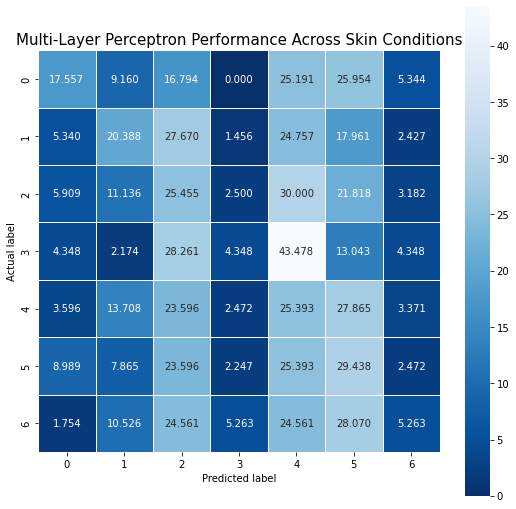

In [181]:
plot_confusion(mlp_model, testing_pc, y_test, "Multi-Layer Perceptron")